# Bayesian Experimental Design for model selection

Script used to perform optimisation where a 6 step experiment is being design considering the product of the Bhattacharyya distances of RFP and GFP for the two models

   ............................................................................................................................................................................................................................................

### Import Required libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
from numba import jit
import gaussianprocess as gp
from fitderiv import fitderiv
import genutils as gu
import datetime
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import math


### Model 1 Functions (ODEs, Steady State and Event based representation)
* Lugagne et. al. Model

In [2]:
@jit
def model1(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    
    if u_IPTG > y[0]:
        dInd_dt[0]=k_in_IPTG*(u_IPTG-y[0])
    else:
        dInd_dt[0]=k_out_IPTG*(u_IPTG-y[0])
    
    if u_aTc > y[2]:
        dInd_dt[1]=k_in_aTc*(u_aTc-y[1])
    else:
        dInd_dt[1]=k_out_aTc*(u_aTc-y[1])
    
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState1(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode1(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState1(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model1,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 2 Functions (ODEs, Steady State and Event based representation)
* Intermediate Model (Single rate, no degradation)

In [3]:
@jit
def model2(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0]);
    dInd_dt[1] = k_aTc*(u_aTc-y[1]);
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState2(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode2(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState2(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model2,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 3 Functions (ODEs, Steady State and Event based representation)
* Lucia's Model

In [4]:
@jit
def model3(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0])-0.0165*y[0];
    dInd_dt[1] = k_aTc*(u_aTc-y[1])-0.0165*y[1];
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState3(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(4)
    alpha[0] = (k_IPTG*u_IPTG)/(k_IPTG+0.0165)
    alpha[1] = (k_aTc*u_aTc)/(k_aTc+0.0165)
    alpha[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(alpha[1]/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(alpha[0]/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode3(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    
    y_al = SteadyState3(p,ivss) # Calculation of initial guesses for steady state
    
    ssv = odeint(model3,y_al,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]
        
        
        
    
    return(final)

### Functions to simulate the 3 models for all parameter draws

In [5]:
def solveALL (ts, pD, sp, inputs, ivss, pre, model):
    
    AllSol = np.empty((len(ts),len(pD[:,1])*2))
    AllSolTest = np.empty(((round(len(ts)/5)+1),len(pD[:,1])*2))
    for drawInd in range(0,len(pD[:,1])):
        
        p = pD[drawInd,:]
        if model == 'M1':
            temp = solve_coupled_ode1(ts, p, sp, inputs, ivss, pre)
        elif model == 'M2':
            temp = solve_coupled_ode2(ts, p, sp, inputs, ivss, pre)
        elif model == 'M3':
            temp = solve_coupled_ode3(ts, p, sp, inputs, ivss, pre)
        else:
            print('Please, select a correct model as M1, M2 or M3 for the desired one')

        AllSolTest[:,drawInd] = temp[:,2][::5]
        AllSolTest[:,drawInd+(len(pD[:,1]))] = temp[:,3][::5]

    return(AllSolTest)
    

### Example:

In [6]:
ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
inputs = np.empty(18) # What needs to be optimised    --> example: [1e-7,100,1,1e-7]*4+[1e-7,100]
evnT = [int(i) for i in list(np.linspace(0,(24*60),10))]
t = np.linspace(0,(24*60),(24*60)+1)
pM3 = np.asarray(pd.read_csv("ParametersCSV/draws_ALL_Model3.stan.csv"))

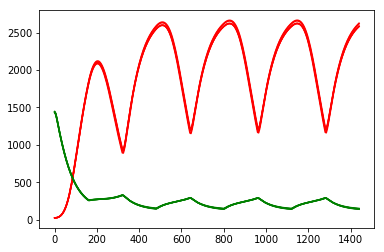

In [7]:
p = pM3[0:5,:]
test = solveALL(t,p,evnT,[1e-7,100,1,1e-7]*4+[1e-7,100],ivss,pre, 'M3')
plt.figure()
plt.plot(t[::5], test[:,0:5], 'r')
plt.plot(t[::5], test[:,5:10], 'g')
plt.show()

### Bhattacharyya distance function:

In [8]:

def BhattacharyyaDist (mu1, mu2, sd1, sd2):
    E = (sd1+sd2)/2
    Em1 = np.linalg.inv(E)
    dE = abs(np.linalg.det(E))

    t1 = np.matrix.transpose((np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))))
    t2 = np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))
    
    ft = (1/8)*t1*Em1*t2
    st = dE/np.sqrt(abs(np.linalg.det(sd1))*abs(np.linalg.det(sd2)))
    
    bhd = ft+0.5*np.log(st)
    
    return(float(bhd))



### Definition of the utility function:

In [9]:

def utility2 (IPTG1, IPTG2, IPTG3, IPTG4, IPTG5, IPTG6,
             aTc1, aTc2, aTc3, aTc4, aTc5, aTc6):
    
    # Definition of inputs for the ODEs
        
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7,
              round(IPTG3,2)+1e-7, int(aTc3)+1e-7, round(IPTG4,2)+1e-7, int(aTc4)+1e-7,
              round(IPTG5,2)+1e-7, int(aTc5)+1e-7, round(IPTG6,2)+1e-7, int(aTc6)+1e-7]
    
    # Initial values for steady state and inputs
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(24*60),7))]
    t =  np.linspace(0,(24*60),(24*60)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
    solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
    solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(24*60),round(24*60/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
    muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
    muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
    gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
    gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
    gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
    gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    
    g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
    bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR*bdG)

    return(u_B)
    


### Bayesian Optimisation: 

In [10]:
# Bounded region of parameter space

pbounds = {'IPTG1': (0, 1), 'IPTG2': (0, 1), 'IPTG3': (0, 1), 'IPTG4': (0, 1),
           'IPTG5': (0, 1), 'IPTG6': (0, 1),
           'aTc1': (0, 100), 'aTc2': (0, 100), 'aTc3': (0, 100), 'aTc4': (0, 100), 
           'aTc5': (0, 100), 'aTc6': (0, 100)}


Setting Bayesian Optimisation with our utility function

In [11]:
optimizer3 = BayesianOptimization(
    f=utility2,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1324,
) 

Begin optimisation rutine

In [25]:
optimizer3.maximize(
    init_points=0,
    n_iter=200,
    alpha=1e-2,
    n_restarts_optimizer=3, 
#     acq="ei", 
#     xi=1e-4
)

|   iter    |  target   |   IPTG1   |   IPTG2   |   IPTG3   |   IPTG4   |   IPTG5   |   IPTG6   |   aTc1    |   aTc2    |   aTc3    |   aTc4    |   aTc5    |   aTc6    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  805      |  5.317e+0 |  0.5583   |  0.5704   |  0.8825   |  0.7954   |  0.9035   |  0.2823   |  46.73    |  1.307    |  1.822    |  12.57    |  4.847    |  92.31    |
|  806      |  1.464e+0 |  0.02531  |  0.7837   |  0.8188   |  0.4663   |  0.3262   |  0.6813   |  91.08    |  23.79    |  13.93    |  2.799    |  94.12    |  77.92    |
|  807      |  1.785e+0 |  0.9013   |  0.7411   |  0.576    |  0.3384   |  0.4268   |  0.9741   |  40.88    |  81.07    |  54.85    |  9.722    |  63.15    |  30.78    |
|  808      |  1.973e+0 |  0.01466  |  0.4269   |  0.8207   |  0.5959   |  0.2645   |  0.1316   |  4.728    |  67.36    |  65.66    |  56.43    |  99.

|  816      |  1.079e+0 |  0.9196   |  0.7171   |  0.2526   |  0.3642   |  0.5234   |  0.9507   |  5.413    |  26.79    |  46.62    |  66.48    |  55.68    |  22.0     |
|  817      |  5.888e+0 |  0.5093   |  0.319    |  0.2446   |  0.5825   |  0.04389  |  0.7958   |  12.49    |  69.37    |  12.76    |  63.63    |  0.3209   |  47.03    |
|  818      |  8.957e+0 |  0.2365   |  0.4291   |  0.7832   |  0.5694   |  0.4879   |  0.6928   |  13.12    |  37.86    |  18.3     |  57.82    |  90.37    |  56.0     |
|  819      |  1.378e+0 |  0.07407  |  0.874    |  0.6425   |  0.9843   |  0.689    |  0.008887 |  37.79    |  40.72    |  57.44    |  0.8225   |  31.78    |  25.31    |
|  820      |  2.035e+0 |  0.3969   |  0.7143   |  0.4043   |  0.1852   |  0.06305  |  0.1397   |  98.08    |  78.19    |  94.34    |  36.13    |  90.48    |  42.04    |
|  821      |  3.387e+0 |  0.3735   |  0.8606   |  0.3511   |  0.7965   |  0.5457   |  0.288    |  61.33    |  77.07    |  40.85    |  98.76    |  82.

|  826      |  9.56e+04 |  0.2378   |  0.1428   |  0.2514   |  0.02664  |  0.9173   |  0.8071   |  18.6     |  70.08    |  14.32    |  97.45    |  61.47    |  67.62    |
|  827      |  2.295e+0 |  0.2655   |  0.4693   |  0.2558   |  0.3957   |  0.04954  |  0.6773   |  76.43    |  45.87    |  87.15    |  42.74    |  39.96    |  68.79    |
|  828      |  3.939e+0 |  0.1226   |  0.6769   |  0.123    |  0.08566  |  0.3722   |  0.632    |  22.82    |  16.26    |  69.87    |  54.83    |  86.01    |  17.23    |
|  829      |  2.099e+0 |  0.5997   |  0.984    |  0.4004   |  0.0347   |  0.1116   |  0.5931   |  39.4     |  33.27    |  41.04    |  38.8     |  71.42    |  39.19    |
|  830      |  1.344e+0 |  0.2797   |  0.7349   |  0.7422   |  0.9296   |  0.6536   |  0.2478   |  80.21    |  1.065    |  44.2     |  71.38    |  40.48    |  53.33    |
|  831      |  8.328e+0 |  0.8946   |  0.2905   |  0.7219   |  0.008725 |  0.4767   |  0.9433   |  2.413    |  82.98    |  20.02    |  5.841    |  49.

|  837      |  3.759e+0 |  0.1209   |  0.4715   |  0.6415   |  0.03709  |  0.5504   |  0.3993   |  83.33    |  65.77    |  66.52    |  15.62    |  93.63    |  71.74    |
|  838      |  2.839e+0 |  0.7276   |  0.7663   |  0.05432  |  0.5173   |  0.3037   |  0.5445   |  46.93    |  58.29    |  24.37    |  61.31    |  92.04    |  54.84    |
|  839      |  1.253e+0 |  0.05286  |  0.2976   |  0.3089   |  0.06848  |  0.3937   |  0.2312   |  5.867    |  66.93    |  53.48    |  19.93    |  31.01    |  4.709    |
|  840      |  5.18e+05 |  0.405    |  0.7732   |  0.5204   |  0.0467   |  0.3172   |  0.9521   |  76.26    |  49.17    |  34.34    |  48.31    |  53.74    |  15.35    |
|  841      |  5.305e+0 |  0.8726   |  0.7469   |  0.8543   |  0.7201   |  0.8412   |  0.6947   |  32.95    |  39.99    |  43.0     |  7.288    |  31.54    |  78.23    |
|  842      |  2.562e+0 |  0.7271   |  0.8292   |  0.3956   |  0.08721  |  0.6525   |  0.876    |  23.78    |  47.94    |  90.8     |  10.55    |  65.

|  849      |  6.308e+0 |  0.9005   |  0.1328   |  0.3378   |  0.04724  |  0.1302   |  0.1265   |  1.081    |  84.26    |  41.68    |  20.88    |  98.61    |  3.372    |
|  850      |  4.366e+0 |  0.4092   |  0.6095   |  0.7693   |  0.3129   |  0.7837   |  0.6593   |  77.32    |  86.13    |  28.88    |  68.66    |  43.43    |  23.11    |
|  851      |  8.928e+0 |  0.8306   |  0.001187 |  0.6885   |  0.9515   |  0.06876  |  0.1836   |  85.64    |  41.75    |  49.92    |  49.98    |  47.76    |  57.89    |
|  852      |  1.188e+0 |  0.4561   |  0.3161   |  0.2891   |  0.4458   |  0.8259   |  0.9973   |  97.43    |  66.21    |  3.821    |  11.55    |  15.96    |  17.92    |
|  853      |  7.9e+06  |  0.1877   |  0.2938   |  0.8715   |  0.6533   |  0.9021   |  0.5814   |  50.4     |  49.92    |  81.9     |  70.28    |  71.15    |  45.64    |
|  854      |  2.226e+0 |  0.9845   |  0.8029   |  0.03706  |  0.2372   |  0.5343   |  0.1301   |  98.6     |  5.224    |  98.84    |  18.63    |  57.

|  860      |  9.932e+0 |  0.5007   |  0.4275   |  0.7021   |  0.6253   |  0.6551   |  0.464    |  5.897    |  47.67    |  88.14    |  15.62    |  20.02    |  42.91    |
|  861      |  7.402e+0 |  0.2963   |  0.8405   |  0.618    |  0.0445   |  0.7923   |  0.6924   |  86.78    |  33.81    |  96.03    |  18.54    |  28.66    |  81.62    |
|  862      |  2.064e+0 |  0.03323  |  0.639    |  0.6907   |  0.2446   |  0.7198   |  0.02896  |  29.51    |  5.581    |  94.43    |  60.31    |  1.595    |  23.07    |
|  863      |  1.803e+0 |  0.6563   |  0.4804   |  0.457    |  0.5891   |  0.09286  |  0.5961   |  68.98    |  5.381    |  62.51    |  83.83    |  16.2     |  94.45    |
|  864      |  4.08e+04 |  0.7677   |  0.6114   |  0.07873  |  0.3592   |  0.1541   |  0.693    |  69.06    |  48.45    |  77.3     |  74.92    |  14.66    |  42.01    |
|  865      |  9.445e+0 |  0.6866   |  0.6281   |  0.1698   |  0.9382   |  0.4507   |  0.5691   |  12.99    |  26.59    |  21.61    |  72.77    |  19.

|  872      |  5.072e+0 |  0.5092   |  0.2886   |  0.1603   |  0.1344   |  0.9393   |  0.6785   |  88.07    |  32.11    |  21.61    |  13.01    |  15.92    |  37.6     |
|  873      |  1.368e+0 |  0.1989   |  0.2093   |  0.5689   |  0.4776   |  0.7984   |  0.4395   |  71.34    |  74.9     |  98.47    |  8.156    |  56.36    |  4.412    |
|  874      |  5.159e+0 |  0.7197   |  0.9477   |  0.248    |  0.4596   |  0.4085   |  0.9929   |  29.67    |  18.81    |  3.45     |  32.22    |  81.51    |  77.66    |
|  875      |  3.849e+0 |  0.9291   |  0.4028   |  0.5038   |  0.8688   |  0.07021  |  0.1621   |  52.15    |  2.108    |  11.46    |  59.49    |  1.754    |  43.93    |
|  876      |  4.844e+0 |  0.3056   |  0.2806   |  0.3327   |  0.4376   |  0.9651   |  0.8396   |  32.99    |  4.153    |  65.89    |  30.38    |  18.4     |  62.7     |
|  877      |  1.213e+0 |  0.7689   |  0.7473   |  0.7941   |  0.7982   |  0.9511   |  0.0684   |  21.17    |  60.87    |  88.88    |  22.01    |  18.

|  884      |  4.49e+04 |  0.4365   |  0.3521   |  0.6393   |  0.7566   |  0.06729  |  0.6943   |  42.31    |  57.47    |  35.53    |  59.28    |  0.9486   |  85.53    |
|  885      |  5.14e+05 |  0.9132   |  0.4741   |  0.8444   |  0.03316  |  0.7155   |  0.08444  |  74.84    |  76.8     |  39.17    |  4.084    |  17.52    |  93.19    |
|  886      |  1.71e+06 |  0.5413   |  0.08517  |  0.7903   |  0.544    |  0.619    |  0.253    |  14.62    |  16.1     |  79.23    |  20.57    |  42.71    |  60.54    |
|  887      |  2.291e+0 |  0.2058   |  0.8146   |  0.6615   |  0.8813   |  0.732    |  0.6648   |  71.4     |  8.82     |  59.4     |  60.65    |  36.47    |  16.99    |
|  888      |  9e+05    |  0.7254   |  0.6863   |  0.1637   |  0.03031  |  0.2553   |  0.02442  |  27.99    |  42.23    |  38.85    |  56.28    |  90.93    |  76.29    |
|  889      |  3.628e+0 |  0.9901   |  0.2961   |  0.656    |  0.9175   |  0.02679  |  0.1376   |  55.66    |  28.8     |  21.81    |  33.6     |  56.

|  895      |  1.484e+0 |  0.8676   |  0.2676   |  0.5557   |  0.3043   |  0.7772   |  0.5119   |  39.36    |  24.63    |  26.22    |  18.45    |  90.63    |  19.32    |
|  896      |  3.155e+0 |  0.3      |  0.1227   |  0.9886   |  0.4633   |  0.7805   |  0.5005   |  61.88    |  49.83    |  21.81    |  96.91    |  9.907    |  52.03    |
|  897      |  4.484e+0 |  0.6863   |  0.3736   |  0.3919   |  0.9496   |  0.5089   |  0.9226   |  16.65    |  67.5     |  59.97    |  40.25    |  82.46    |  4.713    |
|  898      |  1.196e+0 |  0.2503   |  0.8547   |  0.858    |  0.2015   |  0.9283   |  0.4465   |  87.26    |  1.051    |  24.22    |  72.78    |  54.97    |  44.39    |
|  899      |  8.446e+0 |  0.336    |  0.1792   |  0.01795  |  0.3371   |  0.4617   |  0.641    |  4.671    |  98.26    |  91.9     |  52.34    |  51.54    |  79.55    |
|  900      |  6.98e+05 |  0.615    |  0.6831   |  0.1523   |  0.6891   |  0.6878   |  0.03908  |  70.88    |  42.91    |  68.54    |  16.05    |  29.

|  906      |  8.851e+0 |  0.6488   |  0.03125  |  0.8343   |  0.664    |  0.3022   |  0.9465   |  8.229    |  49.66    |  12.42    |  0.04868  |  96.12    |  49.17    |
|  907      |  3.038e+0 |  0.4741   |  0.3859   |  0.3582   |  0.1149   |  0.8936   |  0.2716   |  27.23    |  54.36    |  56.05    |  57.7     |  37.52    |  77.21    |
|  908      |  1.288e+0 |  0.7618   |  0.8815   |  0.3366   |  0.6087   |  0.114    |  0.1685   |  56.31    |  54.31    |  6.16     |  35.35    |  16.02    |  78.95    |
|  909      |  1.851e+0 |  0.5801   |  0.8748   |  0.03006  |  0.554    |  0.5042   |  0.2366   |  67.1     |  1.027    |  90.21    |  75.89    |  21.04    |  10.63    |
|  910      |  3.646e+0 |  0.2868   |  0.289    |  0.7831   |  0.4036   |  0.5512   |  0.8      |  9.095    |  9.079    |  20.65    |  22.52    |  24.86    |  75.34    |
|  911      |  3.341e+0 |  0.1199   |  0.1969   |  0.8977   |  0.9155   |  0.8844   |  0.1708   |  16.85    |  64.12    |  4.766    |  70.64    |  25.

|  918      |  1.767e+0 |  0.02504  |  0.876    |  0.04498  |  0.3486   |  0.8613   |  0.7559   |  79.9     |  1.329    |  50.71    |  93.47    |  86.99    |  53.56    |
|  919      |  5.394e+0 |  0.4188   |  0.3345   |  0.8382   |  0.4869   |  0.5749   |  0.4784   |  83.17    |  25.72    |  92.5     |  78.69    |  27.91    |  1.295    |
|  920      |  3.45e+04 |  0.2344   |  0.7045   |  0.5415   |  0.1488   |  0.4326   |  0.4386   |  89.76    |  84.22    |  20.44    |  88.25    |  94.77    |  45.13    |
|  921      |  4.927e+0 |  0.189    |  0.6142   |  0.6121   |  0.5349   |  0.6101   |  0.4197   |  57.14    |  33.83    |  19.72    |  86.15    |  40.85    |  31.89    |
|  922      |  2.402e+0 |  0.2155   |  0.6728   |  0.1421   |  0.6644   |  0.1118   |  0.6651   |  52.48    |  55.41    |  89.01    |  38.36    |  95.15    |  86.16    |
|  923      |  2.348e+0 |  0.1206   |  0.4172   |  0.5356   |  0.5452   |  0.3907   |  0.318    |  87.21    |  13.91    |  7.828    |  44.43    |  44.

|  930      |  4.387e+0 |  0.7468   |  0.666    |  0.1016   |  0.8595   |  0.1386   |  0.6368   |  37.35    |  81.68    |  33.8     |  52.18    |  92.53    |  71.38    |
|  931      |  1.252e+0 |  0.6754   |  0.8582   |  0.9078   |  0.5498   |  0.07107  |  0.4792   |  1.604    |  5.624    |  92.61    |  75.07    |  73.98    |  55.71    |
|  932      |  5.842e+0 |  0.965    |  0.9373   |  0.1126   |  0.9042   |  0.04257  |  0.6523   |  39.13    |  89.47    |  8.616    |  11.64    |  49.73    |  26.38    |
|  933      |  2.366e+0 |  0.1041   |  0.5037   |  0.1049   |  0.6316   |  0.07967  |  0.01686  |  31.41    |  0.971    |  53.4     |  13.07    |  79.44    |  59.72    |
|  934      |  4.39e+06 |  0.6668   |  0.933    |  0.9819   |  0.2829   |  0.4226   |  0.4436   |  88.91    |  59.04    |  24.9     |  1.723    |  0.45     |  48.44    |
|  935      |  5.334e+0 |  0.6197   |  0.5363   |  0.1002   |  0.3      |  0.1398   |  0.7807   |  35.43    |  86.88    |  25.91    |  66.09    |  32.

|  941      |  7.58e+06 |  0.4653   |  0.2342   |  0.8427   |  0.5977   |  0.431    |  0.6901   |  26.21    |  83.9     |  74.18    |  32.1     |  14.62    |  29.02    |
|  942      |  5.096e+0 |  0.885    |  0.1521   |  0.4997   |  0.2376   |  0.0885   |  0.1686   |  8.372    |  15.93    |  97.37    |  68.77    |  95.37    |  2.884    |
|  943      |  5.431e+0 |  0.1542   |  0.2745   |  0.4209   |  0.9481   |  0.05436  |  0.3299   |  80.21    |  93.06    |  43.34    |  25.92    |  85.8     |  23.84    |
|  944      |  3.976e+0 |  0.1014   |  0.3751   |  0.642    |  0.407    |  0.2491   |  0.8104   |  55.53    |  2.504    |  99.35    |  22.41    |  5.815    |  62.45    |
|  945      |  3.385e+0 |  0.4112   |  0.4019   |  0.453    |  0.4128   |  0.4647   |  0.7222   |  12.48    |  11.56    |  91.48    |  58.08    |  66.93    |  60.04    |
|  946      |  7.38e+07 |  0.75     |  0.9177   |  0.02603  |  0.5648   |  0.5143   |  0.1934   |  23.33    |  15.35    |  97.85    |  64.75    |  11.

|  951      |  1.455e+0 |  0.07951  |  0.7528   |  0.7669   |  0.9447   |  0.4864   |  0.5282   |  9.067    |  73.85    |  73.82    |  75.44    |  49.91    |  85.72    |
|  952      |  1.476e+0 |  0.3587   |  0.4076   |  0.2433   |  0.4475   |  0.7911   |  0.272    |  14.92    |  9.894    |  53.16    |  79.11    |  69.13    |  40.8     |
|  953      |  7.683e+0 |  0.8442   |  0.6618   |  0.9731   |  0.2954   |  0.05432  |  0.2603   |  24.71    |  8.39     |  15.13    |  81.1     |  98.17    |  30.93    |
|  954      |  1.271e+0 |  0.5119   |  0.5803   |  0.1127   |  0.3041   |  0.4799   |  0.3219   |  67.8     |  10.37    |  80.68    |  52.1     |  97.05    |  81.78    |
|  955      |  1.437e+0 |  0.03518  |  0.5904   |  0.9594   |  0.0153   |  0.3323   |  0.05734  |  40.85    |  10.81    |  83.56    |  31.41    |  26.03    |  63.77    |
|  956      |  6.146e+0 |  0.7597   |  0.8959   |  0.5092   |  0.09169  |  0.6351   |  0.2857   |  48.92    |  21.27    |  47.16    |  52.15    |  95.

|  962      |  1.039e+0 |  0.9823   |  0.614    |  0.6104   |  0.6977   |  0.4876   |  0.0846   |  31.78    |  43.75    |  78.29    |  99.33    |  4.018    |  8.573    |
|  963      |  1.617e+0 |  0.5628   |  0.263    |  0.07725  |  0.4967   |  0.3117   |  0.572    |  10.65    |  62.94    |  39.9     |  8.631    |  92.98    |  46.7     |
|  964      |  1.828e+0 |  0.2114   |  0.4636   |  0.05472  |  0.438    |  0.8967   |  0.5467   |  80.5     |  43.94    |  13.36    |  87.32    |  60.5     |  96.62    |
|  965      |  1.265e+0 |  0.4221   |  0.8006   |  0.8918   |  0.2482   |  0.9152   |  0.26     |  88.63    |  24.11    |  88.6     |  45.87    |  46.95    |  32.4     |
|  966      |  1.083e+0 |  0.7213   |  0.4714   |  0.2845   |  0.197    |  0.3909   |  0.5313   |  40.58    |  69.44    |  92.65    |  46.41    |  96.53    |  2.57     |
|  967      |  1.957e+0 |  0.1731   |  0.2314   |  0.1785   |  0.5688   |  0.01019  |  0.568    |  90.56    |  8.199    |  5.321    |  3.033    |  88.

|  975      |  1.235e+0 |  0.8968   |  0.6903   |  0.7238   |  0.2728   |  0.1173   |  0.1427   |  53.85    |  55.5     |  24.48    |  25.02    |  75.62    |  98.91    |
|  976      |  3.375e+0 |  0.5881   |  0.1931   |  0.2997   |  0.1969   |  0.08209  |  0.9453   |  89.1     |  12.88    |  11.75    |  20.42    |  53.11    |  54.49    |
|  977      |  2.959e+0 |  0.2728   |  0.5333   |  0.4792   |  0.8922   |  0.06982  |  0.9602   |  50.36    |  69.62    |  43.41    |  50.4     |  43.23    |  98.8     |
|  978      |  8.502e+0 |  0.6903   |  0.8279   |  0.3268   |  0.05457  |  0.2759   |  0.7184   |  39.72    |  25.22    |  49.34    |  83.37    |  68.66    |  1.745    |
|  979      |  1.326e+0 |  0.962    |  0.5471   |  0.03252  |  0.4008   |  0.4146   |  0.2828   |  1.014    |  50.46    |  94.85    |  55.95    |  22.11    |  62.58    |
|  980      |  3.805e+0 |  0.4413   |  0.6842   |  0.02958  |  0.2478   |  0.8521   |  0.9424   |  28.36    |  10.71    |  71.28    |  54.19    |  72.

|  985      |  5.162e+0 |  0.8508   |  0.1656   |  0.2526   |  0.8931   |  0.7667   |  0.3079   |  58.27    |  79.4     |  94.92    |  51.78    |  15.27    |  53.88    |
|  986      |  4.545e+0 |  0.9182   |  0.8487   |  0.2412   |  0.8552   |  0.07511  |  0.3651   |  85.75    |  91.58    |  25.86    |  0.1294   |  62.63    |  21.05    |
|  987      |  7.894e+0 |  0.1615   |  0.1158   |  0.5803   |  0.9298   |  0.415    |  0.3425   |  2.712    |  35.74    |  31.44    |  76.64    |  61.95    |  57.11    |
|  988      |  1.878e+0 |  0.3843   |  0.1954   |  0.1552   |  0.3677   |  0.5625   |  0.8521   |  28.59    |  98.37    |  52.15    |  12.75    |  98.06    |  54.6     |
|  989      |  5.1e+05  |  0.5064   |  0.7288   |  0.6983   |  0.3824   |  0.3629   |  0.2474   |  56.94    |  59.51    |  24.6     |  78.45    |  31.87    |  76.95    |
|  990      |  6.421e+0 |  0.4978   |  0.7147   |  0.2332   |  0.4507   |  0.5351   |  0.3161   |  45.93    |  81.32    |  77.27    |  17.82    |  10.

|  997      |  2.837e+0 |  0.04124  |  0.8918   |  0.906    |  0.7229   |  0.4596   |  0.1617   |  39.57    |  4.734    |  52.29    |  35.93    |  63.09    |  30.1     |
|  998      |  3.232e+0 |  0.8817   |  0.1011   |  0.2423   |  0.7637   |  0.3421   |  0.04883  |  75.29    |  69.03    |  61.4     |  27.75    |  73.23    |  68.73    |
|  999      |  2.022e+0 |  0.3401   |  0.2291   |  0.5767   |  0.2772   |  0.9322   |  0.5602   |  19.1     |  92.71    |  19.53    |  47.36    |  6.007    |  96.2     |
|  1000     |  3.008e+0 |  0.5741   |  0.6726   |  0.1875   |  0.6374   |  0.4343   |  0.1531   |  81.58    |  71.97    |  50.79    |  36.39    |  43.48    |  38.9     |
|  1001     |  4.119e+0 |  0.5023   |  0.9176   |  0.9693   |  0.8334   |  0.8802   |  0.6876   |  69.83    |  83.46    |  39.37    |  75.76    |  91.94    |  36.43    |
|  1002     |  1.564e+0 |  0.6106   |  0.0969   |  0.9836   |  0.4153   |  0.3784   |  0.1329   |  27.05    |  25.08    |  17.79    |  53.92    |  15.

In [26]:
# Save results obtained
with open('config6sMultiplicative3.optim', 'wb') as config_optim_file:
 
    pickle.dump(optimizer3, config_optim_file)
    

In [27]:
# Best utility value generated
print(optimizer3.max)

{'target': 2371610713.806932, 'params': {'IPTG1': 0.2619913803979486, 'IPTG2': 0.36696256964309565, 'IPTG3': 0.7796951692778881, 'IPTG4': 0.60989234742719, 'IPTG5': 0.8342830189024909, 'IPTG6': 0.9174090434483333, 'aTc1': 27.36275854456235, 'aTc2': 28.798180342843125, 'aTc3': 25.030436753146446, 'aTc4': 11.258524513979522, 'aTc5': 36.92994953590364, 'aTc6': 8.17305443842995}}


Plot best utility value so far per iteration: 

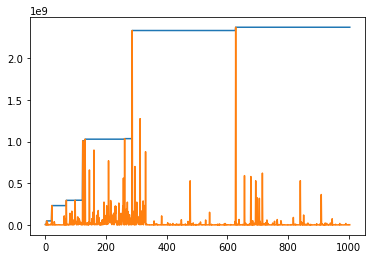

In [28]:
v = []
for i, res in enumerate(optimizer3.res):
    v.append(res['target'])
    
vn = []
for i, val in enumerate(v):
    mv = max(v[0:i+1])
    vn.append(mv)
    
plt.figure()
plt.plot(vn)
plt.plot(v)
plt.show()

In [29]:
df = pd.DataFrame({
    'CFV': v})
df.to_csv('CFV_Iter_6S_Multiplicative.csv')

df = pd.DataFrame({
    'CFV': vn})
df.to_csv('bestCFV_Iter_6S_Multiplicative.csv')

### Check results with plot

In [23]:
inputs = [round(optimizer3.max['params']['IPTG1'], 2)+1e-7, int(optimizer3.max['params']['aTc1'])+1e-7, 
          round(optimizer3.max['params']['IPTG2'], 2)+1e-7, int(optimizer3.max['params']['aTc2'])+1e-7, 
          round(optimizer3.max['params']['IPTG3'], 2)+1e-7, int(optimizer3.max['params']['aTc3'])+1e-7, 
          round(optimizer3.max['params']['IPTG4'], 2)+1e-7, int(optimizer3.max['params']['aTc4'])+1e-7, 
          round(optimizer3.max['params']['IPTG5'], 2)+1e-7, int(optimizer3.max['params']['aTc5'])+1e-7, 
          round(optimizer3.max['params']['IPTG6'], 2)+1e-7, int(optimizer3.max['params']['aTc6'])+1e-7]

ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
sp = [int(i) for i in list(np.linspace(0,(24*60),7))]
t =  np.linspace(0,(24*60),(24*60)+1)

pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

# Simulation of the system for the two models and extract of results
solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')

RFP_M1 = solM1[:,0:len(pM1[:,1])]
GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

RFP_M2 = solM2[:,0:len(pM2[:,1])]
GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]


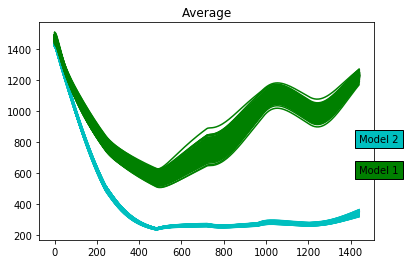

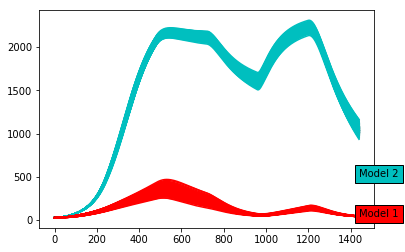

In [24]:
t = np.linspace(0,(24*60),round(24*60/5)+1)

plt.figure()
lines = plt.plot(t, GFP_M2, 'c')
plt.text((24*60)+1, 800, "Model 2", bbox=dict(facecolor='c'))
plt.title("Average")
lines2 = plt.plot(t, GFP_M1, 'g')
plt.text((24*60)+1, 600, "Model 1", bbox=dict(facecolor='g'))

plt.show()
plt.figure()
plt.plot(t, RFP_M2, 'c')

plt.text((24*60)+1, 500, "Model 2", bbox=dict(facecolor='c'))
plt.text((24*60)+1, 40, "Model 1", bbox=dict(facecolor='r'))
plt.plot(t, RFP_M1, 'r')
plt.show()

### Check utility decomposition results

In [ ]:
# Gaussian Process Regression and Reduction

# Means and standard deviations for each time point for each species and for each model
tgp = np.linspace(0,(24*60),(24*60/5)+1)

muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
sdR3 = RFP_M2.std(axis = 1)
muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
sdG3 = GFP_M2.std(axis = 1)
muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
sdR2 = RFP_M1.std(axis = 1)
muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
sdG2 = GFP_M1.std(axis = 1)

# Gaussian Process regression
gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
gR3.findhyperparameters(noruns=15)
gR3.predict(tgp)

gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
gG3.findhyperparameters(noruns=15)
gG3.predict(tgp)

gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
gR2.findhyperparameters(noruns=15)
gR2.predict(tgp)

gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
gG2.findhyperparameters(noruns=15)
gG2.predict(tgp)



In [ ]:
muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R2.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G2.predict(tref)

In [ ]:
bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
u_B = (bdR*bdG)

In [ ]:
print("The BD for RFP is: ", str(bdR))
print("The BD for GFP is: ", str(bdG))
print("The multiplicative BD is: ", str(u_B))